In [ ]:
import Pkg

Pkg.add("SparseArrays")
Pkg.add("LinearAlgebra")
Pkg.add("SpecialFunctions")
Pkg.add("Arpack")   
Pkg.add("DelimitedFiles")
Pkg.add("NPZ")
Pkg.add("Random")
Pkg.add("Statistics")
Pkg.add("ExpmV")

In [ ]:
using SparseArrays
using LinearAlgebra
using SpecialFunctions  # for besselj
using Arpack  # for eigs on sparse matrices
using Statistics
using Random
using DelimitedFiles
using NPZ
using ExpmV


In [ ]:
function von_neumann_entropy(ψ::Vector{<:Complex}, cut::Int, L::Int)
    dimA = 3^cut
    dimB = 3^(L - cut)
    ψ_matrix = reshape(ψ, (dimA, dimB))
    svals = svdvals(ψ_matrix)
    S = 0.0
    for s in svals
        p = abs2(s)
        if p > 0 && p > 1e-15
            S -= p * log(p)
        end
    end
    return S
end

In [ ]:
using LinearAlgebra
using Random

function random_product_state(L::Int)
    product_state = nothing

    for i in 1:L
        θ1 = rand() * π
        θ2 = rand() * π
        ϕ1 = rand() * 2π
        ϕ2 = rand() * 2π

        c1 = cos(θ1 / 2)
        c2 = exp(im * ϕ1) * sin(θ1 / 2) * sin(θ2 / 2)
        c3 = exp(im * ϕ2) * sin(θ1 / 2) * cos(θ2 / 2)

        temp_state = [c1, c2, c3]

        if i == 1
            product_state = temp_state
        else
            product_state = kron(product_state, temp_state)
        end
    end

    # Normalize the state
    product_state /= norm(product_state)

    return product_state
end

In [ ]:
function Hamiltonian(L)
    # Define Pauli matrices as complex sparse matrices
    id = sparse(ComplexF64[1 0 0; 0 1 0; 0 0 1])
    sx = 1/sqrt(2) * sparse(ComplexF64[0 1 0; 1 0 1; 0 1 0])
    sy = 1/sqrt(2) * sparse(ComplexF64[0 -im 0; im 0 -im; 0 im 0])
    sz = sparse(ComplexF64[1 0 0; 0 0 0; 0 0 -1])

    sp = 1/sqrt(2) * (sx + im * sy)
    sm = 1/sqrt(2) * (sx - im * sy)

    # Preallocate vectors of operators with correct type
    #sx_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    #sy_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    szl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz operators
    sz2l = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz² operators
    spl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sp operators
    sml = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sm operators

    for i_site in 1:L
        p_ops = fill(id, L)
        m_ops = fill(id, L)
        z_ops = fill(id, L)
        z2_ops = fill(id, L)
        p_ops[i_site] = sp
        m_ops[i_site] = sm
        z_ops[i_site] = sz
        z2_ops[i_site] = sz^2

        # Build the full operator by tensoring
        P = p_ops[1]
        M = m_ops[1]
        Z = z_ops[1]
        Z2 = z2_ops[1]
        for j in 2:L
            P = kron(P, p_ops[j])
            M = kron(M, m_ops[j])
            Z = kron(Z, z_ops[j])
            Z2 = kron(Z2, z2_ops[j])
        end

        spl[i_site] = P
        sml[i_site] = M
        szl[i_site] = Z
        sz2l[i_site] = Z2
    end

    dim = 3^L
    H = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        H += ((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2) + adjoint((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2)))
    end

    return H, sz2l, szl 
end

In [ ]:
using ExpmV

function time_evolution(ψ::Vector{ComplexF64}, dt::Float64, L)
    ψ /= norm(ψ)
    H, _, _ = Hamiltonian(L)

    # Apply exp(-im * H * dt) directly to ψ
    ψ_new = expmv(-im * dt, H, ψ)

    # Normalize the state
    ψ_new /= norm(ψ_new)
    
    return ψ_new
end


In [ ]:
state = time_evolution(random_product_state(13), 1.0, 13)

In [ ]:
von_neumann_entropy(state, 6, 13)

In [ ]:
function Entropy_t(L::Int, T::Float64, dt::Float64, p::Float64, direction::String, shot::Int)
    Random.seed!(shot)  # Set random seed
    s_t = random_product_state(L)
    S_list = Float64[]

    # Define Hamiltonian and local observables
    H, sz2l, szl = Hamiltonian(L)
    
    if direction == "Z2"
        sm_list = sz2l
    elseif direction == "Z"
        sm_list = szl
    else
        error("Invalid direction: $direction. Choose \"Z2\" or \"Z\".")
    end


    steps = Int(floor(T / dt))

    for _ in 1:steps
        push!(S_list, von_neumann_entropy(s_t, L÷2, L))
        #push!(S_list, I3(s_t))

        # Time evolution
        s_t = time_evolution(s_t, dt)
        s_t /= norm(s_t)

        # Measurements
        if p != 0
            for l in 1:L
                x = rand()
                if x < p
                    m_op = sm_list[l]
                    p_m = real(s_t' * (m_op * s_t))
                    if rand() < p_m
                        s_t = (m_op * s_t) / sqrt(p_m)
                    else
                        s_t = (s_t - m_op * s_t) / sqrt(1 - p_m)
                    end
                end
            end
        end
    end

    # Save result to disk
    filename = "L$(L),T$(T),dt$(dt),p$(p),dir$(direction),s$(shot).npy"
    #npzwrite(filename, S_list)

    return S_list
end

In [ ]:
Entropy_t(8, 100.0, 1.0, 1.0, "Z2", 1)

In [ ]:
function I3(psi::Vector{ComplexF64})
    log3(x) = log(x) / log(3)

    L = Int(round(log3(length(psi))))
    qL = L ÷ 4

    SA   = von_neumann_entropy(psi, qL, L)
    SB   = von_neumann_entropy(psi, 2qL, L)
    SC   = von_neumann_entropy(psi, 3qL, L)
    SABC = von_neumann_entropy(psi, L, L)
    SAB  = von_neumann_entropy(psi, 2qL, L)
    SAC  = von_neumann_entropy(psi, 3qL, L)
    SBC  = von_neumann_entropy(psi, 3qL, L)
    


    return SA + SB + SC + SABC - SAB - SAC - SBC
end

In [ ]:
function Entropy_t_z(L::Int, T::Float64, dt::Float64, p::Float64, shot::Int)
    Random.seed!(shot)  # Set random seed
    s_t = random_product_state(L)
    S_list = Float64[]

    # Define Hamiltonian and local observables
    H, sz2l, szl = Hamiltonian(L)
    sm_list = szl
    steps = Int(floor(T / dt))

    for _ in 1:steps
        push!(S_list, von_neumann_entropy(s_t, L÷2, L))
        #push!(S_list, I3(s_t))

        # Time evolution
        s_t = time_evolution(s_t, dt)
        s_t /= norm(s_t)

        # Measurements
        if p != 0
            for l in 1:L
                x = rand()
                if x < p
                    m_op = sm_list[l]
                    p_m_mone = 0.5 * real(s_t' * (sz2l[l]-sm_list[l]) * s_t)
                    p_m_one = 0.5 * real(s_t' * (sz2l[l] + sm_list[l]) * s_t)
                    x1 = rand()
                    if x1 < p_m_mone
                        s_t = 0.5 * ((sz2l[l]-sm_list[l]) * s_t) / sqrt(p_m_mone)
                    elseif p_m_mone < x1 < p_m_one + p_m_mone
                        s_t = 0.5 * ((sz2l[l]+sm_list[l]) * s_t) / sqrt(p_m_one)
                    else
                        s_t = (s_t - sz2l[l] * s_t) / sqrt(1 - p_m_mone - p_m_one)
                    end
                end
            end
        end
    end

    # Save result to disk
    filename = "L$(L),T$(T),dt$(dt),p$(p),dirZ,s$(shot).npy"
    npzwrite(filename, S_list)

    return S_list
end

In [ ]:
include("s3.jl")

In [ ]:
Entropy_t_z(8, 100.0, 1.0, 0.3, 398)

for L in [8]
    for T in [100.0]
        for dt in [1.0]
            for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                for shot in 1:500
                    Entropy_t_z(L, T, dt, p, shot)
                end
            end
        end
    end
end

This took 320 minutes to run

### Ancilla purification code

In [ ]:
using SparseArrays
using LinearAlgebra
using Arpack
using Statistics
using Random
using DelimitedFiles
using NPZ
using ExpmV

function von_neumann_entropy(ψ::Vector{<:Complex}, cut::Int, L::Int)
    dimA = 3^cut
    dimB = 3^(L - cut)
    ψ_matrix = reshape(ψ, (dimA, dimB))
    svals = svdvals(ψ_matrix)
    S = 0.0
    for s in svals
        if s > 1e-15
            p = abs2(s)
            S -= p * log(p)
        end
    end
    return S
end

function random_product_state(L::Int)
    product_state = nothing

    for i in 1:L
        θ1 = rand() * π
        θ2 = rand() * π
        ϕ1 = rand() * 2π
        ϕ2 = rand() * 2π

        c1 = cos(θ1 / 2)
        c2 = exp(im * ϕ1) * sin(θ1 / 2) * sin(θ2 / 2)
        c3 = exp(im * ϕ2) * sin(θ1 / 2) * cos(θ2 / 2)

        temp_state = [c1, c2, c3]

        if i == 1
            product_state = temp_state
        else
            product_state = kron(product_state, temp_state)
        end
    end

    # Normalize the state
    product_state /= norm(product_state)

    return product_state
end

function time_evolution(ψ::Vector{ComplexF64}, dt::Float64, L)
    ψ /= norm(ψ)
    Ha, Hb, Hc, _, _ = Hamiltonian(L)
    a = 2π * rand()
    b = 2π * rand()
    c = 2π * rand()
    # Apply exp(-im * H * dt) directly to ψ
    H = a * Ha + b * Hb + c * Hc
    ψ_new = expmv(-im * dt, H, ψ)

    # Normalize the state
    ψ_new /= norm(ψ_new)
    
    return ψ_new
end

function I3(psi::Vector{ComplexF64})
    log3(x) = log(x) / log(3)

    L = Int(round(log3(length(psi))))
    qL = L ÷ 4

    SA   = von_neumann_entropy(psi, qL, L)
    SB   = von_neumann_entropy(psi, 2qL, L)
    SC   = von_neumann_entropy(psi, 3qL, L)
    SABC = von_neumann_entropy(psi, L, L)
    SAB  = von_neumann_entropy(psi, 2qL, L)
    SAC  = von_neumann_entropy(psi, 3qL, L)
    SBC  = von_neumann_entropy(psi, 3qL, L)
    
    return SA + SB + SC + SABC - SAB - SAC - SBC
end

### This function is for Z measurements only

function Entropy_t_z(L::Int, T::Float64, dt::Float64, p::Float64, shot::Int)
    Random.seed!(shot)  # Set random seed
    s_t = random_product_state(L)
    S_list = Float64[]

    # Define Hamiltonian and local observables
    _, _, _, sz2l, szl = Hamiltonian(L)
    sm_list = szl
    steps = Int(floor(T / dt))

    for _ in 1:steps
        #push!(S_list, von_neumann_entropy(s_t, L÷2, L))
        push!(S_list, I3(s_t))

        # Time evolution
        s_t = time_evolution(s_t, dt, L)
        s_t /= norm(s_t)

        # Measurements
        if p != 0
            for l in 1:L
                x = rand()
                if x < p
                    m_op = sm_list[l]
                    p_m_mone = 0.5 * real(s_t' * (sz2l[l]-sm_list[l]) * s_t)
                    p_m_one = 0.5 * real(s_t' * (sz2l[l] + sm_list[l]) * s_t)
                    x1 = rand()
                    if x1 < p_m_mone
                        s_t = 0.5 * ((sz2l[l]-sm_list[l]) * s_t) / sqrt(p_m_mone)
                    elseif p_m_mone < x1 < p_m_one + p_m_mone
                        s_t = 0.5 * ((sz2l[l]+sm_list[l]) * s_t) / sqrt(p_m_one)
                    else
                        s_t = (s_t - sz2l[l] * s_t) / sqrt(1 - p_m_mone - p_m_one)
                    end
                end
            end
        end
    end

    # Save result to disk
    filename = "L$(L),T$(T),dt$(dt),p$(p),dirZ,s$(shot).npy"
    npzwrite(filename, S_list)

    return S_list
end

function Hamiltonian(L)
    # Define Pauli matrices as complex sparse matrices
    id = sparse(ComplexF64[1 0 0; 0 1 0; 0 0 1])
    sx = 1/sqrt(2) * sparse(ComplexF64[0 1 0; 1 0 1; 0 1 0])
    sy = 1/sqrt(2) * sparse(ComplexF64[0 -im 0; im 0 -im; 0 im 0])
    sz = sparse(ComplexF64[1 0 0; 0 0 0; 0 0 -1])

    sp = 1/sqrt(2) * (sx + im * sy)
    sm = 1/sqrt(2) * (sx - im * sy)

    # Preallocate vectors of operators with correct type
    #sx_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    #sy_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    szl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz operators
    sz2l = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz² operators
    spl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sp operators
    sml = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sm operators

    for i_site in 1:L
        p_ops = fill(id, L)
        m_ops = fill(id, L)
        z_ops = fill(id, L)
        z2_ops = fill(id, L)
        p_ops[i_site] = sp
        m_ops[i_site] = sm
        z_ops[i_site] = sz
        z2_ops[i_site] = sz^2

        # Build the full operator by tensoring
        P = p_ops[1]
        M = m_ops[1]
        Z = z_ops[1]
        Z2 = z2_ops[1]
        for j in 2:L
            P = kron(P, p_ops[j])
            M = kron(M, m_ops[j])
            Z = kron(Z, z_ops[j])
            Z2 = kron(Z2, z2_ops[j])
        end

        spl[i_site] = P
        sml[i_site] = M
        szl[i_site] = Z
        sz2l[i_site] = Z2
    end

    dim = 3^L
    Ha = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Ha += ((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2) + adjoint((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2)))
    end

    Hb = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hb += (spl[i] * szl[i] * sml[ip] * szl[ip] + sml[i] * szl[i] * spl[ip] * szl[ip] + adjoint(spl[i] * szl[i] * sml[ip] * szl[ip]) + adjoint(sml[i] * szl[i] * spl[ip] * szl[ip]))
    end

    Hc = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hc += (spl[i]^2 * spl[ip] * szl[ip] + sml[i]^2 * sml[ip] * szl[ip] + adjoint(spl[i]^2 * spl[ip] * szl[ip]) + adjoint(sml[i]^2 * sml[ip] * szl[ip]))
    end

    return Ha, Hb, Hc, sz2l, szl 
end

In [ ]:
function Hamiltonian(L)
    # Define Pauli matrices as complex sparse matrices
    id = sparse(ComplexF64[1 0 0; 0 1 0; 0 0 1])
    sx = 1/sqrt(2) * sparse(ComplexF64[0 1 0; 1 0 1; 0 1 0])
    sy = 1/sqrt(2) * sparse(ComplexF64[0 -im 0; im 0 -im; 0 im 0])
    sz = sparse(ComplexF64[1 0 0; 0 0 0; 0 0 -1])

    sp = 1/sqrt(2) * (sx + im * sy)
    sm = 1/sqrt(2) * (sx - im * sy)

    # Preallocate vectors of operators with correct type
    #sx_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    #sy_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    szl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz operators
    sz2l = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz² operators
    spl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sp operators
    sml = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sm operators

    for i_site in 1:L
        p_ops = fill(id, L)
        m_ops = fill(id, L)
        z_ops = fill(id, L)
        z2_ops = fill(id, L)
        p_ops[i_site] = sp
        m_ops[i_site] = sm
        z_ops[i_site] = sz
        z2_ops[i_site] = sz^2

        # Build the full operator by tensoring
        P = p_ops[1]
        M = m_ops[1]
        Z = z_ops[1]
        Z2 = z2_ops[1]
        for j in 2:L
            P = kron(P, p_ops[j])
            M = kron(M, m_ops[j])
            Z = kron(Z, z_ops[j])
            Z2 = kron(Z2, z2_ops[j])
        end

        spl[i_site] = P
        sml[i_site] = M
        szl[i_site] = Z
        sz2l[i_site] = Z2
    end

    dim = 3^L
    Ha = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Ha += ((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2) + adjoint((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2)))
    end

    Hb = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hb += (spl[i] * szl[i] * sml[ip] * szl[ip] + sml[i] * szl[i] * spl[ip] * szl[ip] + adjoint(spl[i] * szl[i] * sml[ip] * szl[ip]) + adjoint(sml[i] * szl[i] * spl[ip] * szl[ip]))
    end

    Hc = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hc += (spl[i]^2 * spl[ip] * szl[ip] + sml[i]^2 * sml[ip] * szl[ip] + adjoint(spl[i]^2 * spl[ip] * szl[ip]) + adjoint(sml[i]^2 * sml[ip] * szl[ip]))
    end

    return Ha, Hb, Hc, sz2l, szl 
end

In [ ]:
function entropy_vn(ψ::Vector{<:Complex}, L::Int, subsystem::AbstractArray{Int})
    cut = length(subsystem)
    dimA = 3^cut
    dimB = 3^(L - cut)
    ψ_matrix = reshape(ψ, (dimA, dimB))
    svals = svdvals(ψ_matrix)
    S = 0.0
    for s in svals
        if s > 1e-15
            p = abs2(s)
            S -= p * log(p)
        end
    end
    return S
end

Code run

In [ ]:
include("s3.jl")

In [ ]:
@time Entropy_t_z(8, 100.0, 1.0, 0.4, 3980)

### ITensors benchmarking

In [ ]:
function Hamiltonian(L)
    # Define Pauli matrices as complex sparse matrices
    id = sparse(ComplexF64[1 0 0; 0 1 0; 0 0 1])
    sx = 1/sqrt(2) * sparse(ComplexF64[0 1 0; 1 0 1; 0 1 0])
    sy = 1/sqrt(2) * sparse(ComplexF64[0 -im 0; im 0 -im; 0 im 0])
    sz = sparse(ComplexF64[1 0 0; 0 0 0; 0 0 -1])

    sp = 1/sqrt(2) * (sx + im * sy)
    sm = 1/sqrt(2) * (sx - im * sy)

    # Preallocate vectors of operators with correct type
    #sx_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    #sy_list = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L)
    szl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz operators
    sz2l = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sz² operators
    spl = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sp operators
    sml = Vector{SparseMatrixCSC{ComplexF64, Int}}(undef, L) # List of sm operators

    for i_site in 1:L
        p_ops = fill(id, L)
        m_ops = fill(id, L)
        z_ops = fill(id, L)
        z2_ops = fill(id, L)
        p_ops[i_site] = sp
        m_ops[i_site] = sm
        z_ops[i_site] = sz
        z2_ops[i_site] = sz^2

        # Build the full operator by tensoring
        P = p_ops[1]
        M = m_ops[1]
        Z = z_ops[1]
        Z2 = z2_ops[1]
        for j in 2:L
            P = kron(P, p_ops[j])
            M = kron(M, m_ops[j])
            Z = kron(Z, z_ops[j])
            Z2 = kron(Z2, z2_ops[j])
        end

        spl[i_site] = P
        sml[i_site] = M
        szl[i_site] = Z
        sz2l[i_site] = Z2
    end

    dim = 3^L
    Ha = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Ha += ((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2) + adjoint((spl[i]^2 * sml[ip]^2 + sml[i]^2 * spl[ip]^2)))
    end

    Hb = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hb += (spl[i] * szl[i] * sml[ip] * szl[ip] + sml[i] * szl[i] * spl[ip] * szl[ip] + adjoint(spl[i] * szl[i] * sml[ip] * szl[ip]) + adjoint(sml[i] * szl[i] * spl[ip] * szl[ip]))
    end

    Hc = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        ip = (i % L) + 1  # Periodic boundary
        Hc += (spl[i]^2 * spl[ip] * szl[ip] + sml[i]^2 * sml[ip] * szl[ip] + adjoint(spl[i]^2 * spl[ip] * szl[ip]) + adjoint(sml[i]^2 * sml[ip] * szl[ip]))
    end

    return Ha
end

In [ ]:
Ha = Hamiltonian(8)

In [ ]:
## Check if Ha is Hermitian
ishermitian(Ha)

In [ ]:
using LinearAlgebra
using SparseArrays
using Arpack: eigs

In [ ]:
vals, vecs = eigs(Ha; nev=1, which=:SR)
lowest_eig = vals[1]

println("Lowest eigenvalue: ", lowest_eig)

In [ ]:
@show op("S+", s)

In [ ]:
id = [1 0 0; 0 1 0; 0 0 1];
sx = 1/sqrt(2) * [0 1 0; 1 0 1; 0 1 0];
sy = 1/sqrt(2) * [0 -im 0; im 0 -im; 0 im 0];

In [ ]:
sp = 1/sqrt(2) * (sx + im * sy)

In [ ]:
sm = 1/sqrt(2) * (sx - im * sy)

In [ ]:
sp' == sm

In [ ]:
using ITensorMPS

N = 8  #number of sites
sites = siteinds("S=1",N; conserve_qns=true) #spin 1 in each sites

  os = OpSum()
  for j=1:N
    os += 1.0 ,"S+ * S+",j,"S- * S-",mod(j,N)+1   #I think this is the Ham in Sriram's paper
    os += 1.0 ,"S- * S-",j,"S+ * S+",mod(j,N)+1
    os += 1.0 ,"S+ * S+",mod(j,N)+1,"S- * S-",j   # H.c. terms
    os += 1.0 ,"S- * S-",mod(j,N)+1,"S+ * S+",j
    #os += 1.0 ,"S+ * S+",j+1,"S- * S-",j
    #os += 1.0 , "S- * S-", j+1, "S+ * S+",j
  end
  H = MPO(os,sites)

  nsweeps = 15 # number of sweeps is 15
  maxdim = [10,20,100,100,200,200,400,400,500] # gradually increase states kept
  cutoff = [1E-10] # desired truncation error
  
  states = [isodd(n) ? "Up" : "Dn" for n in 1:N] #Neel state-- we know GS is in S^z=0 sector
  psi0 = MPS(sites, states) #constructing the state as MPS which is taken as variational ansatz in next step

  @time energy,psigs = dmrg(H,psi0;nsweeps,maxdim,cutoff);

In [ ]:
using ITensorMPS

N = 8 #number of sites
sites = siteinds("S=1",N; conserve_qns=true) #spin 1 in each sites

  os = OpSum()
  for j=1:N
    os += 1.0 ,"S+ * S+",j,"S- * S-",mod(j,N)+1   #I think this is the Ham in Sriram's paper
    os += 1.0 ,"S- * S-",j,"S+ * S+",mod(j,N)+1
    os += 1.0 ,"S+ * S+",j+1,"S- * S-",j
    os += 1.0 , "S- * S-", j+1, "S+ * S+",j
  end
  H = MPO(os,sites)

  nsweeps = 15 # number of sweeps is 15
  maxdim = [10,20,100,100,200,200,400,400,500] # gradually increase states kept
  cutoff = [1E-10] # desired truncation error
  
  states = [isodd(n) ? "Up" : "Dn" for n in 1:N] #Neel state-- we know GS is in S^z=0 sector
  psi0 = MPS(sites, states) #constructing the state as MPS which is taken as variational ansatz in next step

  energy,psigs = dmrg(H,psi0;nsweeps,maxdim,cutoff);

In [ ]:
using ITensors, ITensorMPS, Random, HDF5, StatsBase
#using Plots

N = 8
sites = siteinds("S=1", N; conserve_qns=true)

os = OpSum()
for j = 1:N ####### change to N-1 if you're doing OBC
  os += 1.0, "S+ * S+", j, "S- * S-", mod(j, N) + 1
  os += 1.0, "S- * S-", j, "S+ * S+", mod(j, N) + 1
  os += 1.0 ,"S+ * S+",mod(j,N)+1,"S- * S-",j   # H.c. terms
  os += 1.0 ,"S- * S-",mod(j,N)+1,"S+ * S+",j
end
H = MPO(os, sites)

# ----- initial product state 
state = [isodd(j) ? "Up" : "Dn" for j in 1:N]       # Néel: isodd(j) ? "Up" : "Dn"
psi = productMPS(sites, state)

#func to compute EE at any site
function entropy_von_neumann(psi, b)
  s = siteinds(psi)
  orthogonalize!(psi, b)
  if b == 1
    U, S, V = svd(psi[b], (siteind(psi, b),))
  else
    U, S, V = svd(psi[b], (linkind(psi, b - 1), siteind(psi, b)))
  end
  SvN = 0.0
  for n in 1:dim(S, 1)
    p = S[n, n]^2
    if p > 0
      SvN -= p * log(p)
    end
  end
  return SvN
end

# ----- TDVP evolution + half-chain entropy at every step -----
tstep = 0.02
tend = 5.0
nsw = round(Int, tend / tstep)
tdvp_maxdim = 500

Time = Float64[]
SvN_half = Float64[]

push!(Time, 0.0)
push!(SvN_half, entropy_von_neumann(psi, N ÷ 2))

for n in 1:nsw
  ncenter = 1
  if maxlinkdim(psi) < tdvp_maxdim
    ncenter = 2
  end

  psi = tdvp(H, -im * tstep, psi;
             time_step = -im * tstep,
             reverse_step = true,
             normalize = false,
             cutoff = 0.0,
             maxdim = tdvp_maxdim,
             nsite = ncenter,
             updater_backend = "exponentiate",
             outputlevel = 1)

  tnow = n * tstep
  push!(Time, tnow)
  push!(SvN_half, entropy_von_neumann(psi, N ÷ 2))

  GC.gc(true)
end

# ----- save results -----
# fname = "SvN_half_vs_time_S1_N$(N)_dt$(tstep)_T$(tend).h5"
# h5write(fname, "time", Time)
# h5write(fname, "SvN_half", SvN_half)
# println("Saved: ", fname)


#plot(Time,SvN_half)
#savefig("SvN_half_vs_time_S1_N$(N)_dt$(tstep)_T$(tend)_tdvp.png")

In [ ]:
1+1

### $(S^{z})^2$ measurements

Using the Lagrange interpolation method, we can construct the following projectors for the operator $(S^{z})^2$:
\begin{equation}
    \mathbf{P}_{0} = (S^{z})^2
\end{equation}

\begin{equation}
    \mathbf{P}_{1 / -1} = \mathbf{I}-(S^{z})^2
\end{equation}

In [ ]:
include("s3.jl")

In [ ]:
function Entropy_t_z2(L::Int, T::Float64, dt::Float64, p::Float64, shot::Int)
    Random.seed!(shot)  # Set random seed
    s_t = random_product_state(L)
    #s_t = neel_spin1_complex(L)  # Use the Néel state as the initial state 
    S_list = Float64[]

    # Define Hamiltonian and local observables
    _, _, _, sz2l, szl = Hamiltonian(L)
    sm_list = szl
    steps = Int(floor(T / dt))

    for _ in 1:steps
        #push!(S_list, entropy_vn(s_t, L, 1:L÷2)) ## Half-chain entropy
        push!(S_list, tmi(s_t))

        # Time evolution
        s_t = time_evolution(s_t, dt, L, shot)
        #s_t /= norm(s_t)

        # Measurements
        if p != 0
            for l in 1:L
                x = rand()
                if x < p
                    p_m_zero = real(s_t' * (sz2l[l]) * s_t)
                    x1 = rand()
                    if x1 < p_m_zero
                        s_t = (sz2l[l] * s_t) / sqrt(p_m_zero)
                    else
                        s_t = (s_t - sz2l[l] * s_t) / sqrt(1 - p_m_zero)
                    end
                end
            end
        end
    end

    """
    # Save result to disk
    filename = "L$(L),T$(T),dt$(dt),p$(p),dirZ2,s$(shot).npy"
    npzwrite(filename, S_list)
    

    """
    folder = "/Users/uditvarma/Documents/s3_data/data_i3"
    filename = joinpath(folder, "L$(L),T$(T),dt$(dt),p$(p),dirZ2,s$(shot)_i3.npy")
    npzwrite(filename, S_list)
    #"""
    
    return S_list
end

In [ ]:
for L in [5, 6]
    T = 10.0 * L
    for dt in [1.0]
        for p in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
            for shot in 1:50
                Entropy_t_z2(L, T, dt, p, shot)
            end
        end
    end
end

In [ ]:
function total_Sz2(L)
    _, _, _, Hd, sz2l, _ = Hamiltonian(L)  # get sz² list from your Hamiltonian builder
    dim = 3^L
    Sz2_tot = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        Sz2_tot += sz2l[i]
    end

    return Sz2_tot
end

In [ ]:
include("s3_anc.jl")

function total_Sz(L)
    _, _, _, _, _, _, szl = Hamiltonian_an(L)  # get sz² list from your Hamiltonian builder
    dim = 3^L
    Sz_tot = spzeros(ComplexF64, dim, dim)

    for i in 1:L
        Sz_tot += szl[i]
    end

    return Sz_tot
end

In [ ]:
using LinearAlgebra

"""
    zero_state(N::Int)

Construct the quantum state |000...0⟩ of N spin-1 sites,
where each site is in the m=0 eigenstate of Sz.
Returns a vector of length 3^N.
"""
function zero_state(N::Int)
    # Local spin-1 basis states
    m_pos1 = [1.0, 0.0, 0.0]  # |m=-1>
    m_0    = [0.0, 1.0, 0.0]  # |m=0>
    m_neg1 = [0.0, 0.0, 1.0]  # |m=+1>
    
    # Start with the first site
    state = m_pos1
    
    # Tensor product across sites
    for i in 2:N
        state = kron(state, m_pos1)
    end

    state = ComplexF64.(state)  # Convert to complex type
    
    return state
end

# Example usage
ψ = zero_state(7)

In [ ]:
ψ' * total_Sz2(7) * ψ

In [ ]:
include("s3.jl")

In [ ]:
include("s3.jl")

function total_Sz2_t(L::Int, T::Float64, dt::Float64, shot::Int)
    Random.seed!(shot)  # Set random seed make this truly random
    s_t = random_product_state(L)
    #s_t = zero_state(L)
    Sz2_list = Float64[]
    #expec = Float64[]

    Sz2_op = total_Sz2(L)

    steps = Int(floor(T / dt))

    for _ in 1:steps
        #push!(S_list, entropy_vn(s_t, L, 1:L÷2)) ## Half-chain entropy
        push!(Sz2_list, real(s_t' * Sz2_op * s_t))
        #push!(expec, real(s_t' * (Hb * total_Sz2(L) - total_Sz2(L) * Hb) * s_t) / L)

        # Time evolution
        s_t = time_evolution(s_t, dt, L, shot)
        #s_t /= norm(s_t)
    end


    return Sz2_list
end

In [ ]:
include("s3.jl")
total_Sz2_t(7, 50.0, 1.0, 987)

In [ ]:
include("s3.jl")

function Entropy_t_z2(L::Int, T::Float64, dt::Float64, p::Float64, shot::Int)
    Random.seed!(shot)  # Set random seed
    s_t = random_product_state(L)
    #s_t = neel_spin1_complex(L)  # Use the Néel state as the initial state 
    S_list = Float64[]

    # Define Hamiltonian and local observables
    _, _, _, _, He, sz2l, szl = Hamiltonian(L)
    steps = Int(floor(T / dt))

    for _ in 1:steps
        push!(S_list, entropy_vn(s_t, L, 1:L÷2)) ## Half-chain entropy
        #push!(S_list, tmi(s_t))

        # Time evolution
        s_t = time_evolution(s_t, dt, L, shot)
        #s_t /= norm(s_t)

        # Measurements
        if p != 0
            for l in 1:L
                x = rand()
                if x < p
                    p_m_zero = real(s_t' * (sz2l[l]) * s_t)
                    x1 = rand()
                    if x1 < p_m_zero
                        s_t = (sz2l[l] * s_t) / sqrt(p_m_zero)
                    else
                        s_t = (s_t - sz2l[l] * s_t) / sqrt(1 - p_m_zero)
                    end
                end
            end
        end
    end

    """
    # Save result to disk
    filename = "L$(L),T$(T),dt$(dt),p$(p),dirZ2,s$(shot).npy"
    npzwrite(filename, S_list)
    

    """
    folder = "/Users/uditvarma/Documents/s3_data/data_hc"
    filename = joinpath(folder, "L$(L),T$(T),dt$(dt),p$(p),dirZ2,s$(shot).npy")
    npzwrite(filename, S_list)
    #"""
    
    return S_list
end

In [ ]:
include("s3.jl")

In [ ]:
for L in [5, 6, 7]
    T = 10.0 * L
    for dt in [1.0]
        for p in [0.0]
            for shot in 1:50
                Entropy_t_z2(L, T, dt, p, shot)
            end
        end
    end
end

In [ ]:
include("s3.jl")
Ha, Hb, Hc, Hd, He, _, _ = Hamiltonian_an(10)

In [ ]:
(Ha + Hd + He) * total_Sz2(10) - total_Sz2(10) * (Ha + Hd + He)

In [ ]:
using LinearAlgebra

"""
    superposition_state(N::Int)

Construct the normalized superposition state (|000...0⟩ + |111...1⟩)/√2 
for N spin-1 sites. 
Here |0⟩ is the m=0 eigenstate of Sz and |1⟩ is the m=+1 eigenstate.
Returns a vector of length 3^N.
"""
function superposition_state(N::Int)
    # Local spin-1 basis states
    m_pos1 = [1.0, 0.0, 0.0]  # |m=-1>
    m_0    = [0.0, 1.0, 0.0]  # |m=0>  (our "0" state)
    m_neg1 = [0.0, 0.0, 1.0]  # |m=+1> (our "1" state)
    
    # Build |000...0⟩
    state0 = m_0
    for i in 2:N
        state0 = kron(state0, m_0)
    end
    
    # Build |111...1⟩
    state1 = m_pos1
    for i in 2:N
        state1 = kron(state1, m_pos1)
    end
    
    # Superposition (normalized)
    state = (state0 .+ state1) ./ sqrt(2)
    
    return ComplexF64.(state)
end
# Example usage
ψ = superposition_state(7)

In [ ]:
ψ' * total_Sz(7) * ψ

In [ ]:
using LinearAlgebra

"""
    spin1_state(L)

Constructs the spin-1 product state 
⊗_{i=1}^L (1/√3)(|1⟩ + |0⟩ + |-1⟩).
Returns a normalized vector of length 3^L.
"""
function spin1_state(L::Int)
    # single-site state (qutrit: |1>, |0>, |-1>)
    site = (1/sqrt(3)) * [1.0, 1.0, 1.0]   # basis ordered as |1>,|0>,|-1>
    
    ψ = site
    for _ in 2:L
        ψ = kron(ψ, site)
    end
    
    return normalize(ψ)
end 


In [ ]:
psi = spin1_state(8)

In [ ]:
include("s3.jl")

In [ ]:
Entropy_t_z2(7, 70.0, 1.0, 0.0, 1234)

In [ ]:
L = 7;
s_t = spin1_state(L)

Q2_op = total_Sz2(L) * total_Sz2(L)
Q_op = total_Sz2(L)

s_t' * Q2_op * s_t - (s_t' * Q_op * s_t)^2

In [ ]:
for L in [6, 7, 8]
    T = 10.0 * L
    for dt in [1.0]
        for p in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
            for shot in 1:500
                Entropy_t_z2(L, T, dt, p, shot)
            end
        end
    end
end

In [ ]:
include("s3.jl")

function Entropy_t_z2(L::Int, T::Float64, dt::Float64, p::Float64, shot::Int) 
    Random.seed!(shot)  # Set random seed
    #s_t = random_product_state(L)
    s_t = spin1_state(L)  # superposition over all Sz sectors
    S_list = Float64[]
    Q_qnv_list = Float64[]

    Q2_op = total_Sz2(L) * total_Sz2(L)
    Q_op = total_Sz2(L)

    # Define Hamiltonian and local observables
    _, _, _, _, _, sz2l, _ = Hamiltonian(L)

    steps = Int(floor(T / dt))

    for _ in 1:steps
        push!(S_list, entropy_vn(s_t, L, 1:L÷2)) ## Half-chain entropy
        push!(Q_qnv_list, real(s_t' * Q2_op * s_t) - real(s_t' * Q_op * s_t)^2) ## Quantum number variance in a trajectory
        #push!(S_list, tmi(s_t))

        # Time evolution
        s_t = time_evolution(s_t, dt, L, shot)
        #s_t /= norm(s_t)

        # Measurements
        if p != 0
            for l in 1:L
                x = rand()
                if x < p
                    p_m_zero = real(s_t' * (sz2l[l]) * s_t)
                    x1 = rand()
                    if x1 < p_m_zero
                        s_t = (sz2l[l] * s_t) / sqrt(p_m_zero)
                    else
                        s_t = (s_t - sz2l[l] * s_t) / sqrt(1 - p_m_zero)
                    end
                end
            end
        end
    end

    #"""
    # Save result to disk
    filename = "L$(L),T$(T),dt$(dt),p$(p),dirZ2,s$(shot)_hc.npy" ## half-chain entropy
    npzwrite(filename, S_list)
    filenameq = "L$(L),T$(T),dt$(dt),p$(p),dirZ,s$(shot)_qnv.npy" ## QNV variance
    npzwrite(filenameq, Q_qnv_list)

    """
    folder = "/Users/uditvarma/Documents/s3_data/data_hc"
    folderq = "/Users/uditvarma/Documents/s3_data/data_qnv"
    filename = joinpath(folder, "L$(L),T$(T),dt$(dt),p$(p),dirZ2,s$(shot)_hc.npy")
    filenameq = joinpath(folderq, "L$(L),T$(T),dt$(dt),p$(p),dirZ2,s$(shot)_qnv.npy")
    npzwrite(filename, S_list)
    npzwrite(filenameq, Q_qnv_list)
    #"""
    
    return Q_qnv_list
end

In [ ]:
import Pkg; Pkg.add("BenchmarkTools")

In [ ]:
using BenchmarkTools

In [ ]:
@btime Entropy_t_z2(10, 100.0, 1.0, 0.0, 1234)

In [ ]:
@btime Entropy_t_z2(8, 80.0, 1.0, 0.0, 1234)

In [ ]:
@btime Entropy_t_z2(11, 100.0, 1.0, 0.0, 1234)

In [ ]:
println("Hello, World!")

In [ ]:
Entropy_t_z2(8, 80.0, 1.0, 0.0, 1234)

In [ ]:
using Pkg
Pkg.status()

In [ ]:
using Distributed
using NPZ, SparseArrays, LinearAlgebra, Random, ExpmV
using Base.Threads

# ----------------------------
# Launch workers
# ----------------------------
if nprocs() == 1
    addprocs()  # add all available cores by default
end

@everywhere begin
    using NPZ, SparseArrays, LinearAlgebra, Random, ExpmV
    using Base.Threads
    include("s3_eff.jl")  # your Entropy_t_z2 function
end

# ----------------------------
# Parameters
# ----------------------------
L_list = [8, 9]
dt_list = [1.0]
p_list = 0.0:0.1:1.0
num_shots = 50

# ----------------------------
# Worker function: threaded execution
# ----------------------------
@everywhere function run_shot_batch_threads(L, T, dt, p, shot_batch)
    # Pre-build Hamiltonians once per worker
    Ha, Hd, He, sz2l, _ = Hamiltonian(L)
    H = copy(Ha)

    # Threads over shots
    @threads for idx in 1:length(shot_batch)
        shot = shot_batch[idx]
        Entropy_t_z2(L, T, dt, p, shot)
    end
end

# ----------------------------
# Main distributed loop
# ----------------------------
for L in L_list
    T = 10.0 * L
    for dt in dt_list
        for p in p_list
            shots = 1:num_shots
            num_workers = nprocs()
            
            # Split shots into round-robin chunks for workers
            chunks = [shots[i:num_workers:end] for i in 1:num_workers]

            @sync for (i, shot_chunk) in enumerate(chunks)
                # Each worker uses all threads to process its chunk
                @async remotecall_wait(run_shot_batch_threads, i, L, T, dt, p, shot_chunk)
            end
        end
    end
end

In [ ]:
include("s3.jl")

In [ ]:
for L in [5, 6]
    for T in [60.0]
        for dt in [1.0]
            for p in [0.3]
                for shot in 1:50
                    Entropy_t_z2(L, T, dt, p, shot)
                end
            end
        end
    end
end

New code trial

In [ ]:
include("s3_new.jl")

In [ ]:
spin1_state(5)

In [ ]:
Ha, Hb, Hc, Hd, He = Hamiltoniann(8)

In [ ]:
using LinearAlgebra, SparseArrays

A_dense = Matrix(Ha)        # convert sparse to dense
vals = eigvals(A_dense)

In [ ]:
include("s3.jl")

In [ ]:
for L in [5, 6]
    for T in [60.0]
        for dt in [1.0]
            for p in [0.18]
                for shot in 1:50
                    Entropy_t_z2(L, T, dt, p, shot)
                end
            end
        end
    end
end

In [ ]:
include("s3_new.jl")

In [ ]:
for L in [5, 6]
    for T in [60.0]
        for dt in [1.0]
            for p in [0.18]
                for shot in 1:50
                    Entropy_t_z2(L, T, dt, p, shot)
                end
            end
        end
    end
end

In [ ]:
include("s3_new.jl")

In [ ]:
for L in [7]
    for T in [60.0]
        for dt in [1.0]
            for p in [0.0, 0.1, 0.3]
                for shot in 1:50
                    Entropy_t_z2(L, T, dt, p, shot)
                end
            end
        end
    end
end

In [2]:
for L in [8]
    for T in [80.0]
        for dt in [1.0]
            for p in [0.0, 0.01, 0.1]
                for shot in 1:200
                    Entropy_t_z2(L, T, dt, p, shot)
                end
            end
        end
    end
end

In [1]:
include("s3_circuit.jl")

two_qubit_unitary (generic function with 1 method)

In [ ]:
include("s3_new.jl")

In [ ]:
using Pkg
Pkg.status()

In [ ]:
include("s3_new.jl")

In [ ]:
L = 8

Ha, _, _, Hd, He = Hamiltonian(L)
total_Sz2(L)

In [ ]:
(Ha + Hd + He) * total_Sz2(L) - total_Sz2(L) * (Ha + Hd + He)

In [ ]:
Entropy_t_z2(8, 80.0, 1.0, 0.0, 7686)

In [ ]:
for L in [5, 6]
    for T in [60.0]
        for dt in [0.1]
            for p in [0.0]
                for shot in 1:50
                    Entropy_t_z2(L, T, dt, p, shot)
                end
            end
        end
    end
end

In [ ]:
using Distributed
using Base.Threads

# --- setup workers ---
addprocs()   # or addprocs(N)
@everywhere using SparseArrays, LinearAlgebra, Arpack, Statistics, Random, DelimitedFiles, NPZ, ExpmV, Dates

# --- load your functions everywhere ---
@everywhere begin
    include("s3_new.jl")
end

# --- parameters ---
Ls = [6, 7, 8]
dts = [1.0]
ps = 0.0:0.1:1.0
shots = 1:500

jobs = [(L, float(10L), 1.0, p) for L in Ls for p in ps]  # each job = one (L,T,dt,p)

@everywhere const SHOTS = 1:500   # broadcast shots to workers

# --- hybrid run ---
pmap(jobs) do (L, T, dt, p)
    @threads for shot in SHOTS
        Entropy_t_z2(L, T, dt, p, shot)
    end
end

In [ ]:
using Distributed
using Base.Threads

# --- setup workers ---
addprocs()   # or addprocs(N)
@everywhere using SparseArrays, LinearAlgebra, Arpack, Statistics, Random, DelimitedFiles, NPZ, ExpmV, Dates

# --- load your functions everywhere ---
@everywhere begin
    include("s3_new.jl")
end

# --- parameters ---
Ls = [6, 7, 8, 9]
dts = [1.0]
ps = 0.0:0.1:1.0
shots = 1:500

jobs = [(L, float(10L), 1.0, p) for L in Ls for p in ps]  # each job = one (L,T,dt,p)

@everywhere const SHOTS = 1:500   # broadcast shots to workers

# --- hybrid run ---
pmap(jobs) do (L, T, dt, p)
    @threads for shot in SHOTS
        Entropy_t_z2(L, T, dt, p, shot)
    end
end

In [ ]:
include("s3_circuit.jl")

In [ ]:
using Distributed
using Base.Threads

# --- setup workers ---
addprocs(9)   # or addprocs(N)
@everywhere using SparseArrays, LinearAlgebra, Arpack, Statistics, Random, DelimitedFiles, NPZ, ExpmV, Dates

# --- load your functions everywhere ---
@everywhere begin
    include("s3_circuit.jl")
end

# --- parameters ---
Ls = [6, 7, 8, 9, 10, 11, 12]
dts = [1.0]
ps = 0.0:0.1:1.0
shots = 1:2000

jobs = [(L, float(10L), 1.0, p) for L in Ls for p in ps]  # each job = one (L,T,dt,p)

@everywhere const SHOTS = 1:2000   # broadcast shots to workers

# --- hybrid run ---
pmap(jobs) do (L, T, dt, p)
    @threads for shot in SHOTS
        Entropy_t_z2(L, T, dt, p, shot)
    end
end

In [1]:
using Distributed
using Base.Threads

# --- setup workers ---
addprocs(11)   # or addprocs(N)
@everywhere using SparseArrays, LinearAlgebra, Arpack, Statistics, Random, DelimitedFiles, NPZ, ExpmV, Dates

# --- load your functions everywhere ---
@everywhere begin
    include("s3_circuit.jl")
end

# --- parameters ---
Ls = [8]
dts = [1.0]
ps = 0.0:0.1:1.0
shots = 1:500

jobs = [(L, float(10L), 1.0, p) for L in Ls for p in ps]  # each job = one (L,T,dt,p)

@everywhere const SHOTS = 1:500   # broadcast shots to workers

# --- hybrid run ---
pmap(jobs) do (L, T, dt, p)
    @threads for shot in SHOTS
        Entropy_t_z2(L, T, dt, p, shot)
    end
end

11-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [4]:
include("s3_circuit.jl")

Entropy_t_z2(8, 80.0, 1.0, 0.8, 9)

513-element Vector{Float64}:
 1.0
 0.9999999999999999
 1.0
 1.0
 1.0000000000000004
 1.0000000000000007
 1.0000000000000002
 1.0000000000000002
 0.9999999999999999
 0.9999999999999998
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0000000000000002
 0.9999999999999998
 1.0
 1.0
 1.0

In [ ]:
include("s3_circuit.jl")

two_qubit_unitary (generic function with 1 method)

In [ ]:
function create_local_sz2_operator(L::Int, site::Int)
    id, _, _, _, _, _, sz2 = get_spin1_operators()
    ops = fill(id, L)
    ops[site] = sz2
    return build_term(ops)
end

create_local_sz2_operator (generic function with 1 method)

In [ ]:
using LinearAlgebra

function build_state(L::Int)
    up, zero, down = [1,0,0], [0,1,0], [0,0,1]

    # helper: tensor product of array of vectors
    kron_list(vs) = reduce(kron, vs)

    # alternating sequences
    alt_up   = [ (isodd(i) ? up : down) for i in 1:L ]
    alt_down = [ (isodd(i) ? down : up) for i in 1:L ]

    # if L odd, replace last with zero
    if isodd(L)
        alt_up[end]   = zero
        alt_down[end] = zero
    end

    ⊗(a,b) = kron(a,b)

    state1 = kron_list(alt_up)   ⊗ up
    state2 = kron_list(alt_down) ⊗ down
    state3 = kron_list(fill(zero, L)) ⊗ zero

    return state1 + state2 + state3
end

# define ⊗ for clarity


# Example
ψ4 = build_state(4)
ψ5 = build_state(5)


In [20]:
using LinearAlgebra

function build_state(L::Int; normalize::Bool=true)
    up, zero, down = [1.0,0,0], [0,1.0,0], [0,0,1.0]

    kron_list(vs) = reduce(kron, vs)

    # alternating sequences
    alt_up   = [ isodd(i) ? up   : down for i in 1:L ]
    alt_down = [ isodd(i) ? down : up   for i in 1:L ]

    # if L odd, replace last with |0>
    if isodd(L)
        alt_up[end]   = zero
        alt_down[end] = zero
    end

    state1 = kron_list(alt_up)   |> x -> kron(x, up)
    state2 = kron_list(alt_down) |> x -> kron(x, down)
    state3 = kron_list(fill(zero, L)) |> x -> kron(x, zero)

    ψ = state1 + state2 + state3
    ψ = ComplexF64.(ψ)
    return normalize ? ψ / norm(ψ) : ψ
end

# Example
ψ = build_state(6)


2187-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [6]:
include("s3_circuit.jl")

Entropy_an_z2 (generic function with 1 method)

In [23]:
entropy_vn(ψ, 7, 1:6)

1.0986122886681096

In [24]:
log(3)

1.0986122886681098

In [1]:
include("s3_circuit_anc.jl")

Entropy_anc_z2 (generic function with 1 method)

In [8]:
Entropy_anc_z(8, 80.0, 1.0, 0.5, 0)

80-element Vector{Float64}:
  1.0986122886681096
  1.0986122886681098
  1.0986122886681098
  1.0986122886681098
  1.0986122886681098
  1.0986122886681098
  1.0986122886681096
  1.0986122886681098
  1.0986122886681096
  1.0986122886681096
  ⋮
  0.0016633735280076373
  2.904927297652957e-5
  5.352292645303648e-7
  0.0
  2.2204460492503126e-16
  0.0
 -4.440892098500627e-16
  0.6151719626283265
  2.2204460492503126e-16

In [10]:
data = npzread("/Users/uditvarma/Documents/s3_data/data_anc_c/L8,T80.0,dt1.0,p0.5,dirZ,s0_anc.npy")

80-element Vector{Float64}:
  1.0986122886681096
  1.0986122886681098
  1.0986122886681098
  1.0986122886681098
  1.0986122886681098
  1.0986122886681098
  1.0986122886681096
  1.0986122886681098
  1.0986122886681096
  1.0986122886681096
  ⋮
  0.0016633735280076373
  2.904927297652957e-5
  5.352292645303648e-7
  0.0
  2.2204460492503126e-16
  0.0
 -4.440892098500627e-16
  0.6151719626283265
  2.2204460492503126e-16

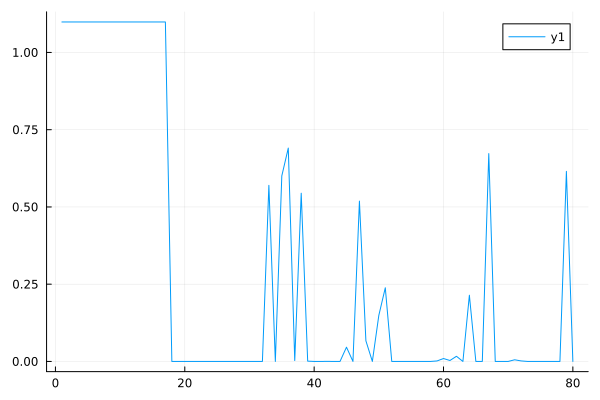

In [11]:
using Plots
plot(data)

In [12]:
using Distributed
using Base.Threads

# --- setup workers ---
addprocs(11)   # or addprocs(N)
@everywhere using SparseArrays, LinearAlgebra, Arpack, Statistics, Random, DelimitedFiles, NPZ, ExpmV, Dates

# --- load your functions everywhere ---
@everywhere begin
    include("s3_circuit_anc.jl")
end

# --- parameters ---
Ls = [6,7,8,9]
dts = [1.0]
ps = 0.0:0.1:1.0
shots = 1:500

jobs = [(L, float(10L), 1.0, p) for L in Ls for p in ps]  # each job = one (L,T,dt,p)

@everywhere const SHOTS = 1:500   # broadcast shots to workers

# --- hybrid run ---
pmap(jobs) do (L, T, dt, p)
    @threads for shot in SHOTS
        Entropy_anc_z(L, T, dt, p, shot)
    end
end

44-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [13]:
# Build the state for N = L+1 sites
function up_down_zero_superposition(N; sparse=false)
    # local basis vectors: |+1>, |0>, |-1>
    up   = [1.0, 0.0, 0.0]   # |+1>
    zero = [0.0, 1.0, 0.0]   # |0>
    down = [0.0, 0.0, 1.0]   # |-1>

    # helper: kron repeated N times
    function kron_chain(v, N)
        result = v
        for _ in 2:N
            result = kron(result, v)
        end
        return result
    end

    # product states
    psi_up   = kron_chain(up, N)
    psi_zero = kron_chain(zero, N)
    psi_down = kron_chain(down, N)

    # build the superposition (they are orthogonal computational basis states)
    psi = psi_up .+ psi_zero .+ psi_down

    # normalize
    normpsi = norm(psi)
    psi ./= normpsi

    return ComplexF64.(psi)
end

up_down_zero_superposition (generic function with 1 method)

In [18]:
up_down_zero_superposition(1)

3-element Vector{ComplexF64}:
 0.5773502691896258 + 0.0im
 0.5773502691896258 + 0.0im
 0.5773502691896258 + 0.0im

In [1]:
include("s3_circuit_anc.jl")

Entropy_anc_z2 (generic function with 1 method)

In [2]:
Entropy_anc_z2(8, 80.0, 1.0, 0.0, 0)

80-element Vector{Float64}:
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 ⋮
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096
 1.0986122886681096

In [4]:
log(3)

1.0986122886681098